# Problem statement

We want to predict the vertical temperature profile of sea ice and the underlying ocean.  We are given three pieces of information:

1. Physics based mathematical/computational model (***forward model***)
2. Information about the parameters based on physical constraints and expert knowledge (***prior information***)
3. Observations and field measurements (***data***)

Consider the physical domain: a two layer-model, where the top layer is sea ice and the bottom layer is ocean.  We insert temperature sensors through the sea ice and into the the top portion of the ocean.

# Project goals

We will characterize probability distributions that describes our "state of knowlege" about the three uncertain parameters: (i) the sea ice thickness, (ii) the thermal conductivity of the ice, and (iii) the thermal conductivity of the ocean.  We first define the prior distribution based on the prior information.  Then, we update this distribution via Bayes' rule given data and the forward model.


# Step 1: import libraries

The numerical tools for this problem are stored in various libraries.  Here, we import these libraries so that we can use them later.

In [1]:
# import matplotlib so that we can make figures
import matplotlib.pyplot as plt

# import numpy for linear algebra in Python
import numpy as np

# import random to generate random numbers in Python
import random

# import the physics-based forward model 
from ForwardModel import BuoyModel

# MUQ libraries
import pymuqModeling as mm # modeling probability distributions
import pymuqSamplingAlgorithms as ms # characterizing probability distributions

# Step 2: the domain

We insert a sensor through the sea ice and into the underlying ocean.  Let $x$ and $z$ be the horizontal and vertical coordinates, respectively.  We assume the temperature profile is constant in the horizontal direction.  Therefore, we only model the vertical profile.

Let's begin by visualizing the problem set up assuming the horizontal domain is normalized to $x \in [-1,1]$ and that the sensor is located at $x=0$.  Additionally:

1. let $z=0$ be the bottom of the sensor and let $z=D$ be the surface of the ice,
2. let the true ice thickness be $h=3$, and
3. the sensor has $n$ nodes that measure the vertical temperature profile, whice are uniformly distributed along its length.

In general, the true ice thickness is unknown.  We use the true value here to visualize the domain and problem set up.

[]

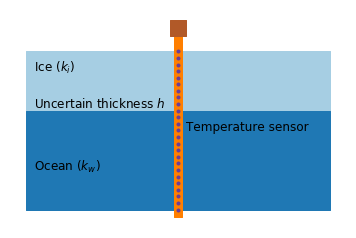

In [2]:
# (normalized) horizontal extent of the ice
x = np.linspace(-1.0, 1.0, num=2)

# total thickness of the domain (ice+ocean)
D = 8.0

# true sea ice thickness (later this will be unknown)
h_true = 3.0

# sensor information
n = 25 # number of sensors
xsensor = np.linspace(-0.05/2.0, 0.05/2.0, num=2) # width of the sensor (for visualization purposes)

# location of the sensors
zobs = np.linspace(0.0, D, num=n)

# visualize the domain
fig = plt.figure()
ax = plt.gca()
# color the ice
ax.fill_between(x, D-h_true, D, color='#a6cee3')
# color the ocean
ax.fill_between(x, 0.0, D-h_true, color='#1f78b4') 
# color the sensor
ax.fill_between(xsensor, 0.0-0.05*D, D+0.1*D, color='#ff7f00') 
# color the top of the sensor
ax.fill_between(2.0*xsensor, D+0.1*D, D+0.2*D, color='#b15928') 
# nodes that read the temperature
ax.plot([0]*n, zobs, 'o', markersize=3, color='#6a3d9a') 
# set plot parameters
ax.text(-0.95, 7.0, 'Ice ($k_i$)', fontsize=12)
ax.text(-0.95, 2.0, 'Ocean ($k_w$)', fontsize=12)
ax.text(-0.95, D-h_true+0.2, 'Uncertain thickness $h$', fontsize=12)
ax.text(0.05, D/2.0, 'Temperature sensor', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Step 3: forward model

The forward model is a physics-based mathematical model that takes (potentially uncertain) parameters as input and predicts the vertical temperature profile.  Let $h$ be the sea ice thickness, $k_i$ be the thermal conductivity of the sea ice, and $k_w$ be the thermal conductivity of the ocean.  

The forward model predicts the vertical temperature profile $T(z)$ by solving the heat equation:

\begin{equation}
   \frac{d}{d z}\left(k(z) \frac{d T}{d z} \right) = 0,
\end{equation}

for $z \in (0,D)$, where $k(z)$ is the thermal conductivity 

\begin{equation}
    k(z) = \begin{cases}
        k_i & \mbox{if } z \leq h \\
        k_w & \mbox{if } z > h.
    \end{cases}
\end{equation}

The boundary conditions are

\begin{equation}
    \begin{array}{ccc}
        T(z=0) = T_{w} & \mbox{and} & \left. k_i \frac{\partial T}{\partial z}\right|_{z=D} = \tau \left(T_{a} - T(z=D)\right).
    \end{array}
\end{equation}

The first boundary condition assumes the temperature at the bottom of the domain (in the ocean) is $T_{w}$, which is known.  The second boundary condition defines a flux into the domain from the atmosphere that is proportional to the difference between the air temperature $T_{a}$ and the ice temperature at the surface $T(z=D)$.  We assume the constant $\tau$ is also known.

Define $\theta = [k_i, k_w, h]$ to be the vector of uncertain parameters.  More generally, we could incorporate $T_{w}$, $T_{a}$ and/or $\tau$ into this vector and allow these parameters to also be uncertain.  For now, however, we assume $T_{w}$, $T_{a}$ and $\tau$ are known.

We can think of the forward model as a function $f: \mathbb{R}^3 \rightarrow \mathbb{R}^n$ that maps the three uncertain parameters to the temperature at the $n$ observation locations.

We have already defined the true ice thickness $h=3$, now lets define the true thermal conductivities $k_i=1$ and $k_w=5$.  We use the forward model to compute the vertical temperature profile given the true values.

(0.0, 8.0)

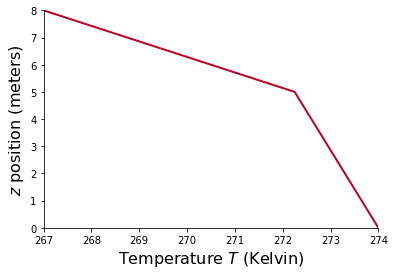

In [3]:
# true parameters
ki_true = 1.0
kw_true = 5.0
theta = [ki_true, kw_true, h_true]

# create the forward model object
model = BuoyModel(zobs, D)

# run the forward model given "true" parameter values
trueSoln = model.Evaluate([np.log(theta)]) [0]

# diagram showing the result (this will also show the ice/ocean layers and the measurement device)
fig = plt.figure()
ax = plt.gca()
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # forward model solution
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_xlim([trueSoln[-1], trueSoln[0]])
ax.set_ylim([zobs[0], zobs[-1]])

# Step 4: prior information

Prior information incorporates information about the uncertain parameters due to physical constraints and expert knowledge.  We model this using a prior distribution. 

In this case, the parameters must be positive ($k_i>0$, $k_w>0$, and $h>0$).  Therefore, we endow them with a log-Gaussin prior

\begin{equation}
    \begin{array}{cccc}
        \log{k_i} \sim N(\bar{k}_i, \sigma_{k_i}^2), & \log{k_w} \sim N(\bar{k}_w, \sigma_{k_w}^2), & \mbox{and} & \log{h} \sim N(\bar{h}, \sigma_h^2).
    \end{array}
\end{equation}

The hyperparameters $\bar{k}_i$, $\bar{k}_w$, and $\bar{h}$ are the mean of the log-Gaussian distributions and $\sigma_{k_i}^2$, $\sigma_{k_w}^2$, and $\sigma_{h}^2$ are the variances.  These are chosen by an expert to reflect 'reasonable' uncertainty based on literature and experience.

We denote the prior distribution over uncertian parameters as $\pi_{\Theta}$ and its probability density is 

\begin{equation}
    \pi_{\Theta}(\log{\theta}) = N(\log{\theta}; \bar{\theta}, \Sigma_{prior})
\end{equation}

where $\bar{\theta} = [\bar{k}_i, \bar{k}_w, \bar{h}]$ is the prior mean and $\Sigma_{prior} = \mbox{diag}\,[\sigma_{k_i}^2, \sigma_{k_w}^2, \sigma_{h}^2]$ is the prior covariance.

We characeterize the *prior predictive distribution* by sampling $\theta^{(i)} \sim \pi_{\Theta}$ from the prior and then evaluating the forward model to get prior predicted temperature profiles $T^{(i)} = f(\theta^{(i)})$.

(0.0, 8.0)

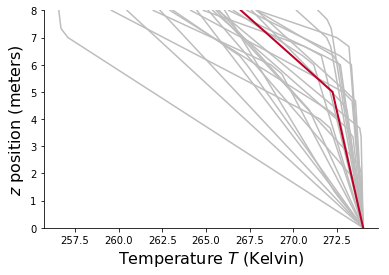

In [9]:
# define the hyperparameters
ki_bar = 0.9
kw_bar = 4.5
h_bar = 2.75
priorMean = np.log([ki_bar, kw_bar, h_bar]) # log-k_ice, log-k_water, log-thickness
sigma2_ki = 0.5
sigma2_kw = 1.0
sigma2_h = 0.75
priorVar = [sigma2_ki, sigma2_kw, sigma2_h] # prior variance

# define the prior probability density
prior = mm.Gaussian(priorMean, priorVar).AsDensity()

# generate 25 prior predicted temperature profiles                    
priorPredictiveSamples = [None]*25
for i in range(len(priorPredictiveSamples)):
    priorPredictiveSamples[i] = model.Evaluate([prior.Sample()]) [0]

# show prior predictive
fig = plt.figure()
ax = plt.gca()
for samp in priorPredictiveSamples:
    ax.plot(samp, zobs, color='#bdbdbd') # true forward model solution
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # true forward model solution
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_ylim([zobs[0], zobs[-1]])

In this figure, the red line is the true vertical temperature profile and the grey lines are the foward model evaluated at prior samples.

# Step 5: data and likelihood

After inserting the sensor into the ice and ocean, we collect noisy observations of the vertical temperature profile.  We use these data $y$ to define the likelihood distribution, which models the probability of making observations $d$ given a parameter value $\theta$.

In our case, we do not have 'real' data.  Therefore, we will generate synthetic data by first evaluating the forward model at the true parameter values and then adding Gaussian noise.  

\begin{equation}
    y = f(\theta_{true}) + \epsilon,
\end{equation}

where $\epsilon \sim N(0, \sigma_{y}^2 I)$.  The hyperparameter $\sigma_y^2 \in \mathbb{R}$ models the noise in the data.

The likelihood distribution $\pi_{Y \vert \Theta}$ uses the model-data mismatch to describe the likelihood of the data given the parameters and forward model.  We assume its probability density function is

\begin{equation}
    \pi_{Y \vert \Theta}(y \vert \theta) = N(y; f(\theta), \sigma_{y}^2 I) \propto \exp{\left(-\sigma_{y} (f(\theta)-y)^T (f(\theta)-y)/2\right)}.
\end{equation}

We can think of the likelihood function $\mathcal{L}(\theta; d) = \log{\pi_{Y \vert \Theta}(y \vert \theta)}$ as a function of the uncertain parameters $\theta$.  

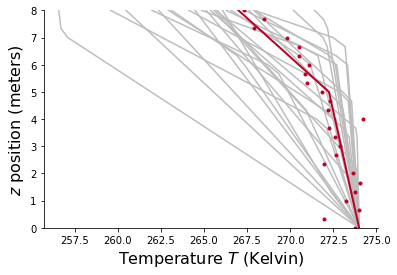

In [10]:
# hyperparameter for noise
sigy = 0.75 # variance

# add the noise to the true solution
noise = mm.Gaussian([0.0]*n, sigy*np.eye(n))
data = trueSoln+noise.Sample()

# show the data on top of prior predictive distribution
fig = plt.figure()
ax = plt.gca()
for samp in priorPredictiveSamples:
    ax.plot(samp, zobs, color='#bdbdbd') # forward model solution
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # true forward model solution
ax.plot(data, zobs, 'o', markersize=3, color='#bd0026') # data
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_ylim([zobs[0], zobs[-1]])

# define the likelihood function
likelihood = mm.Gaussian(data, sigy*np.eye(n)).AsDensity()

In this figure, the red line is the true vertical temperature profile and the grey lines are the foward model evaluated at prior samples.  The red dots are the noisy observations.

# Step 6: posterior

The posterior distribution $\pi_{\Theta \vert Y}$ describes our state of knowledge about the uncertain parameters $\theta$ given observations $y$. Bayes' rule says that the posterior density is given by

\begin{equation}
    \pi_{\Theta \vert Y}(\theta \vert y) \propto \pi_{Y \vert \Theta}(y \vert \theta) \pi_{\Theta}(\theta)
\end{equation}

or, equivalently, 

\begin{equation}
    \log{\pi_{\Theta \vert Y}(\theta \vert y)} \propto \mathcal{L}(\theta; y) + \log{\pi_{\Theta}(\theta)}.
\end{equation}

MUQ allows us to compute the posterior density by breaking it into its components: the prior, the forward model, and the likelihood function.  We have already created these three components.  We, therefore, create a graph such that each node in the graph represents one of these objects.  The edges represent dependences between these components.  

In [11]:
# define the posterior via Bayes' rule
posterior = mm.DensityProduct(2)

# create the graph
graph = mm.WorkGraph()

# create a place holder object for the parameters
para = mm.IdentityOperator(3)

# add the nodes (each node is a component of the posterior)
graph.AddNode(para, 'parameters')
graph.AddNode(prior, 'prior')
graph.AddNode(likelihood, 'likelihood')
graph.AddNode(model, 'forward model')
graph.AddNode(posterior, 'posterior')

# connect the nodes
graph.AddEdge('parameters', 0, 'prior', 0)
graph.AddEdge('parameters', 0, 'forward model', 0)
graph.AddEdge('forward model', 0, 'likelihood', 0)
graph.AddEdge('likelihood', 0, 'posterior', 1)
graph.AddEdge('prior', 0, 'posterior', 0)

graph.Visualize('PosteriorGraph.png')

Here is a visualization of the graph:

![title](PosteriorGraph.png)

The 'parameters' node represents the three unknown parameters.  We can prior and forward model given these parameters and then we can evaluate the likelihood given the forward model result.  Finally, given the prior and likelihood, we can evaluate the posterior.

# Step 7: sampling the posterior

In general, we cannot generate independent and identically distributed (i.i.d.) samples from the posterior distribution.   We, therefore, resort to Markov chain Monte Carlo (MCMC) to generate correlated sample from the posterior distribution.

MCMC constructs a Markov chain whose stationary distribution is the posterior distribution.  As we take more MCMC steps the chain 'explores' the domain, spending more time in regions of higher posterior probability.  

In MUQ, we first create a sampling problem.  This object exposes the target density to the MCMC sampler.  MUQ has a variety of MCMC algorithms, most of which are a variation of a three step structure to generate state $\theta^{(t+1)}$ given $\theta^{(t)}$:

1.  Propose $\theta^{\prime} \sim q_t(. \vert \theta^{(t)})$
2.  Compute the acceptance probability $\alpha(\theta^{(t)}, \theta^{\prime})$
3.  Set $\theta^{(t+1)} = \theta^{\prime}$ with probability $\alpha(\theta^{(t)}, \theta^{\prime})$ (accept the proposal) and $\theta^{(t+1)} = \theta^{(t)}$ otherwise (reject the proposal).

Here, we show adapative Metropolis MCMC, which adapts the proposal distribution $q_t$ based on previous samples:

\begin{equation}
    q(\theta \vert \theta^{(t)}) = N(\theta; \theta^{(t)}, \Sigma_{proposal})
\end{equation}

where

\begin{equation}
    \Sigma_{proposal} = \sigma_a \mbox{cov}\,(x_{(1:t)}) + \epsilon I.
\end{equation}

This proposal has two parameters:

1.  The algorithm parameter $\epsilon$ is a small value to ensure that we can propose in any direction (typically $\epsilon \approx 10^{-10}$
2.  The algorithm parameter $\sigma_a$ is the adaption scale.  

We will now explore how tuning this algorithm parameter affects the result.

In [134]:
# define the sampling problem
problem = ms.SamplingProblem(graph.CreateModPiece("posterior"))

# create MCMC object
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1.0
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 100
proposalOptions['AdaptScale'] = 25.0

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 10000
options['ThinIncrement'] = 1
options['BurnIn'] = 0
options['KernelList'] = 'Kernel'
options['PrintLevel'] = 3
options['Kernel'] = kernelOptions

mcmc = ms.SingleChainMCMC(options, problem)

Next, we run MCMC to generate samples from the posterior distribution $\pi_{\Theta \vert Y}$.

In [135]:
# run MCMC with "good" parameters 
start = np.log([ki_true, kw_true, h_true]) # the first step of the Markov chain
posteriorSamps = mcmc.Run(start)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 4%
  20% Complete
    Block 0:
      Acceptance Rate = 2.8%
  30% Complete
    Block 0:
      Acceptance Rate = 3%
  40% Complete
    Block 0:
      Acceptance Rate = 2.6%
  50% Complete
    Block 0:
      Acceptance Rate = 2.8%
  60% Complete
    Block 0:
      Acceptance Rate = 3%
  70% Complete
    Block 0:
      Acceptance Rate = 3%
  80% Complete
    Block 0:
      Acceptance Rate = 3%
  90% Complete
    Block 0:
      Acceptance Rate = 2.9%
  100% Complete
    Block 0:
      Acceptance Rate = 2.9%
Completed in 95.5314 seconds.


## Diagonstics

MCMC needs to explore the entire domain.  The rate that the MCMC chain moves around the region of high posterior probability is called the mixing.  The acceptance rate is the rate is the frequency with which the proposal is accepted.  In the above run, the acceptance rate is very low $< 3 \%$.  The chain is very slowly moving around the domaing and, therefore, the mixing is slowl

We can plot the mixing by ploting the each state $\theta_i^{(t)}$ as a function of the MCMC step $t$.

Text(0.5,0,'MCMC step')

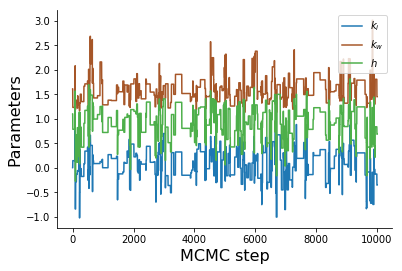

In [136]:
# diagnostics
postSamps = posteriorSamps.AsMatrix()

# mixing
fig = plt.figure()
ax = plt.gca()
colors = ['#1f78b4', '#a65628', '#4daf4a']
labels = ['$k_i$', '$k_w$', '$h$']
for color,label,samp in zip(colors,labels,postSamps):
    ax.plot(samp, color=color, label=label) # trace
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Parameters', fontsize=16)
ax.set_xlabel('MCMC step', fontsize=16)

Visually, we can see that few proposals are accepted and the chain is stationary for long periods of time.  It will, therefore, take a long time to explore the region of high posterior probability.

Note: we could solve this issue by running a longer chain, giving the chain a chance to explore the domain.  However, this is inefficient.

Lets fix this by changing the algorithm parameters and rerunning the chain.

In [137]:
# change the adaptation scale
proposalOptions['AdaptScale'] = 0.01
mcmc = ms.SingleChainMCMC(options, problem)
posteriorSamps = mcmc.Run(start)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 68%
  20% Complete
    Block 0:
      Acceptance Rate = 81%
  30% Complete
    Block 0:
      Acceptance Rate = 84%
  40% Complete
    Block 0:
      Acceptance Rate = 85%
  50% Complete
    Block 0:
      Acceptance Rate = 87%
  60% Complete
    Block 0:
      Acceptance Rate = 88%
  70% Complete
    Block 0:
      Acceptance Rate = 88%
  80% Complete
    Block 0:
      Acceptance Rate = 89%
  90% Complete
    Block 0:
      Acceptance Rate = 89%
  100% Complete
    Block 0:
      Acceptance Rate = 89%
Completed in 97.8782 seconds.


The acceptance rate is now much higher.  However, the mixing plot suggests that MCMC is not exploring the domain.

Text(0.5,0,'MCMC step')

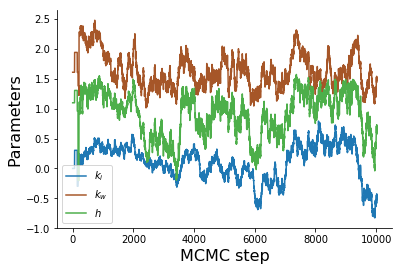

In [138]:
# diagnostics
postSamps = posteriorSamps.AsMatrix()

# mixing
fig = plt.figure()
ax = plt.gca()
colors = ['#1f78b4', '#a65628', '#4daf4a']
labels = ['$k_i$', '$k_w$', '$h$']
for color,label,samp in zip(colors,labels,postSamps):
    ax.plot(samp, color=color, label=label) # trace
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Parameters', fontsize=16)
ax.set_xlabel('MCMC step', fontsize=16)

Now we are accepting frequently but the step size is very small.  The chain will need many of steps before it has explored the domain properly.  Again, we could fix this by running a longer chain, but this is ineffiecient.  Let's try to change the adaptation scale again.

When the adaptation scale was too large we took large, infrequent steps and when the adaptation scale was too small we took frequent small steps.  Let's try an intermediate value.

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 38%
  20% Complete
    Block 0:
      Acceptance Rate = 38%
  30% Complete
    Block 0:
      Acceptance Rate = 38%
  40% Complete
    Block 0:
      Acceptance Rate = 39%
  50% Complete
    Block 0:
      Acceptance Rate = 39%
  60% Complete
    Block 0:
      Acceptance Rate = 38%
  70% Complete
    Block 0:
      Acceptance Rate = 38%
  80% Complete
    Block 0:
      Acceptance Rate = 37%
  90% Complete
    Block 0:
      Acceptance Rate = 37%
  100% Complete
    Block 0:
      Acceptance Rate = 37%
Completed in 101.371 seconds.


Text(0.5,0,'MCMC step')

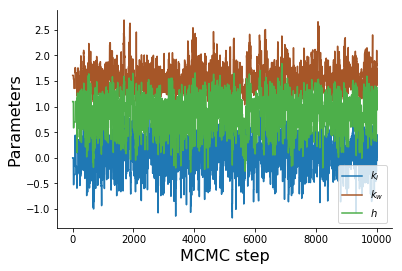

In [139]:
# change the adaptation scale
proposalOptions['AdaptScale'] = 1.0
mcmc = ms.SingleChainMCMC(options, problem)
posteriorSamps = mcmc.Run(start)

# diagnostics
postSamps = posteriorSamps.AsMatrix()

# mixing
fig = plt.figure()
ax = plt.gca()
colors = ['#1f78b4', '#a65628', '#4daf4a']
labels = ['$k_i$', '$k_w$', '$h$']
for color,label,samp in zip(colors,labels,postSamps):
    ax.plot(samp, color=color, label=label) # trace
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Parameters', fontsize=16)
ax.set_xlabel('MCMC step', fontsize=16)

Now our acceptance rate is reasonable and the mixing plot shows that we are exploring the region of high posterior probability!

Although it is difficult to visualize a three dimensional distribution, we can plot the one and two dimensional marginal distributions.

In [144]:
fig = plt.figure()

# pi(theta1)
ax = plt.subplot(331)
ax.hist(postSamps[0], bins=100, density=True, histtype='step', color='#636363')
ax.set_xlim([-1.25, 1.25])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_ylabel(r'$\pi(\theta_1)$', fontsize=10)

# pi(theta1,theta2)
ax = plt.subplot(334)
ax.hist2d(postSamps[0], postSamps[1], bins=25, normed=True, cmap='Greys')
ax.set_xticks([])
ax.set_xlim([-1.25, 1.25])
ax.set_ylim([1.0, 2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r'$\theta_2$', fontsize=10)

# pi(theta2)
ax = plt.subplot(335)
ax.hist(postSamps[1], bins=100, density=True, histtype='step', color='#636363')
ax.set_xlim([1.0, 2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_ylabel(r'$\pi(\theta_2)$', fontsize=10)

# pi(theta1,theta3)
ax = plt.subplot(337)
ax.hist2d(postSamps[0], postSamps[2], bins=25, normed=True, cmap='Greys')
ax.set_xlim([-1.25, 1.25])
ax.set_ylim([-0.5, 1.75])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$\theta_1$', fontsize=10)
ax.set_ylabel(r'$\theta_3$', fontsize=10)

# pi(theta2,theta3)
ax = plt.subplot(338)
ax.hist2d(postSamps[1], postSamps[2], bins=25, normed=True, cmap='Greys')
ax.set_xlim([1.0, 2.5])
ax.set_ylim([-0.5, 1.75])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$\theta_2$', fontsize=10)

# pi(theta3)
ax = plt.subplot(339)
ax.hist(postSamps[2], bins=100, density=True, histtype='step', color='#636363')
ax.set_xlim([-0.5, 1.75])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$\theta_3$', fontsize=10)
ax.set_ylabel(r'$\pi(\theta_3)$', fontsize=10)

Text(0,0.5,'$\\pi(\\theta_3)$')

# Step 8: the posterior predictive distribution

Now that we have used MCMC to generate samples from the posterior distribution, we can characterize the posterior predictive distribution by evaluating the forward model at the posterior samples $T^{(t)} = f(\theta^{(t)})$.  This is similar to the prior predictive distribution, except that the samples are now from the posterior.

Here, we randomly choose $25$ posterior samples to visualize the posterior predicitive distribution.

(0.0, 8.0)

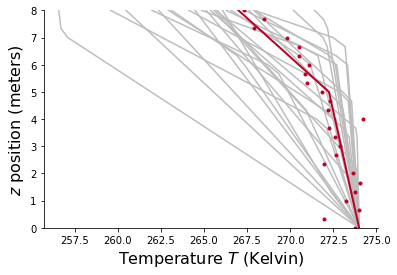

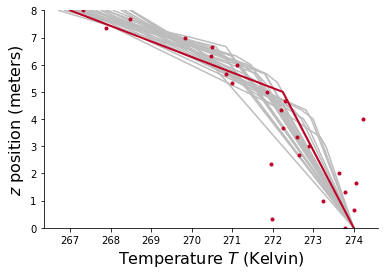

In [145]:
# compute the posterior predictive
posteriorPredictiveSamples = [None]*25
for i in range(len(posteriorPredictiveSamples)):
    ind = random.randint(0, posteriorSamps.size())
    posteriorPredictiveSamples[i] = model.Evaluate([[postSamps[0][ind], postSamps[1][ind], postSamps[2][ind]]]) [0]

# show the data on top of prior predictive distribution
fig = plt.figure()
ax = plt.gca()
for samp in priorPredictiveSamples:
    ax.plot(samp, zobs, color='#bdbdbd') # forward model solution
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # true forward model solution
ax.plot(data, zobs, 'o', markersize=3, color='#bd0026') # data
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_ylim([zobs[0], zobs[-1]])
    
# show the data on top of posterior predictive distribution
fig = plt.figure()
ax = plt.gca()
for samp in posteriorPredictiveSamples:
    ax.plot(samp, zobs, color='#bdbdbd') # forward model solution
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # true forward model solution
ax.plot(data, zobs, 'o', markersize=3, color='#bd0026') # data
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_ylim([zobs[0], zobs[-1]])

Note that the posterior predictive distribution is much more concentrated around the true temperature profile.  This is because we have used the forward model and data to update our 'state of knowledge'.

# Why do we care?

* Probability distributions provide more information than just a "best estimate."  For example, we also know the mean and covariance. 
* Provides a robust way of determining how informative the data/observations are.
* We can propogate uncertainty through predictive models onto quantities of interest or future predictions.

# Conclusion

* We can combine different types of information to constrain uncertain parameter values.  
* Our state of knowledge is described by a probability distribution (e.g., prior and posterior).
* Sampling methods (e.g., MCMC) characterize the distribution.